In [279]:
import json
import re
import time
import logging
import threading
import functools
import collections
from nltk.corpus import words
import spacy.tokenizer, spacy.lemmatizer
import urllib.parse
import nltk
import gensim
import gensim.corpora as corpora
from wordcloud import WordCloud

# logging.basicConfig(format='\r%(asctime)s : %(levelname)s : %(message)s', level=logging.NOTSET)


In [276]:
nltk.download('words')
common_words = set(words.words())

[nltk_data] Downloading package words to
[nltk_data]     /Users/mafuangimemkamon/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [32]:
with open("pages.json", "r") as f:
    pages = json.load(f)

with open("name-visit-count-all.json", "r") as f:
    counts = json.load(f)

f = lambda k: "https://en.wikipedia.org"+urllib.parse.unquote(k)
l = sorted([(v, f(k)) for k,v in counts.items() if v], reverse=True)[:500]
for c, k in l:
    print(c, k)

FileNotFoundError: [Errno 2] No such file or directory: 'pages.json'

In [7]:
nlp = spacy.load('en_core_web_sm')

In [4]:
def clean(text):
    sections = re.split("===* .* ===*", text)
    return [token.lemma_ 
                for token in nlp(sections[0]) 
                if token.is_alpha 
                and not token.is_stop 
                and token.lemma_ not in {'-PRON-', "the", "a", "an"}]

In [67]:
cleaned = {}
counter = 0
for link, (text, cat) in pages.items():
    cleaned[link] = clean(text)
    counter += 1
    counter % 10 or print("\r", counter, link, end="  "*20)

 10000 /wiki/Anton_du_Beke                                                                    

In [79]:
with open("lemmatized-tokenized.json", "r") as f:
    cleaned = json.load(f)

links, documents = zip(*sorted(cleaned.items()))
counts = collections.Counter([w for d in documents for w in d])
documents = [[w for w in d if counts[w] > 20] for d in documents]

In [300]:
id2word = corpora.Dictionary(documents)
corpus = [id2word.doc2bow(text) for text in documents]


3815


In [307]:
from gensim import models
def custom_df2idf(docfreq, totaldocs, log_base=2.0, add=0.0):
    return add + np.log(float(totaldocs) / docfreq)/ np.log(log_base)
    #add + np.log(float(totaldocs) / docfreq) / np.log(log_base)
def idf_smooth(docfreq, totaldocs):
    return np.log(float(totaldocs)/(docfreq+1))
def idf_prob(docfreq, totaldocs):
    return np.log((float(totaldocs)-docfreq)/(docfreq))

tf = models.TfidfModel(corpus, id2word=id2word, smartirs = 'nnn')
sigs = [(id2word[i], sig) for i, sig in tf.idfs.items() if id2word[i] in common_words]
sigs.sort(key = lambda i:-i[1])
sigs[0:20]

[('bear', 8303),
 ('know', 4783),
 ('in', 4345),
 ('film', 3708),
 ('role', 3254),
 ('include', 3234),
 ('win', 2948),
 ('year', 2923),
 ('award', 2903),
 ('play', 2898),
 ('series', 2876),
 ('television', 2827),
 ('actor', 2720),
 ('star', 2584),
 ('career', 2568),
 ('time', 2550),
 ('best', 2444),
 ('actress', 2280),
 ('work', 2269),
 ('lead', 2193)]

## Generate bad word cloud

(-0.5, 1023.5, 719.5, -0.5)

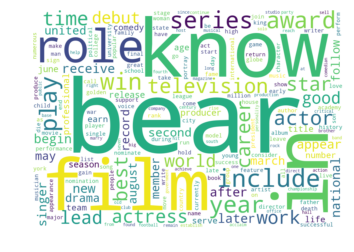

In [313]:
tfidf = models.TfidfModel(corpus, id2word=id2word, wglobal = idf_smooth)
sigs = [(id2word[i], sig, tfidf.idfs.get(i), sig* tfidf.idfs.get(i) ) for i, sig in tf.idfs.items() if id2word[i] in common_words]
sigs.sort(key = lambda i:-i[3])
weight = dict([(item[0], item[1]) for item in sigs])
wordcloud = WordCloud(background_color="white",
    max_words=200,
    width = 1024,
    height = 720)
wordcloud.generate_from_frequencies(weight)
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt

plt.imshow(wordcloud, interpolation='bilinear')
plt.savefig('wordcloud_alternate1.png')
plt.axis("off")

In [292]:
tfidf = models.TfidfModel(corpus, id2word=id2word, wglobal = idf_prob)
mysig = [(id2word[i], sig, tfidf.idfs.get(i), sig* tfidf.idfs.get(i) ) for i, sig in tf.idfs.items() if id2word[i] in common_words]
mysig.sort(key = lambda i:-i[3])
mysig[0:20]


In [305]:
weight = dict([(item[0], item[3]) for item in mysig])
wordcloud = WordCloud(background_color="white",
    max_words=200,
    width = 1024,
    height = 720)
wordcloud.generate_from_frequencies(weight)
# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt

plt.imshow(wordcloud, interpolation='bilinear')
plt.savefig('wordcloud.png')
plt.axis("off")



IndexError: tuple index out of range

0.9310615989515072


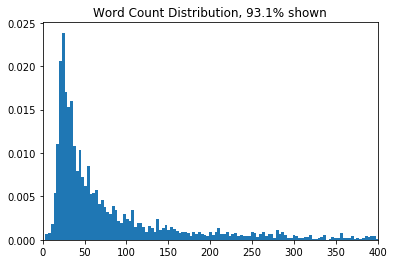

In [197]:
counts = [i for _, i in sigs]
counts.sort(reverse=True)
import random
import matplotlib.pyplot as plt
plt.hist(counts, bins=2500, density=True)
plt.axis([0, 400, 0, None])
plt.title('Word Count Distribution, 93.1% shown')
plt.savefig('Word Count Distribution.png')
print(1 - sum(1 for i in counts if i > 400) / len(counts))
plt.show()

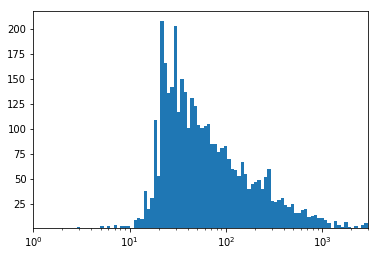

In [182]:
counts = [i for _, i in sigs]
counts.sort(reverse=True)

import matplotlib.pyplot as plt
plt.hist(counts, 
         bins=np.logspace(np.log(1), np.log(1000.0), 200))
plt.axis([1, 3000, 1, None])
plt.xscale("log")
plt.show()


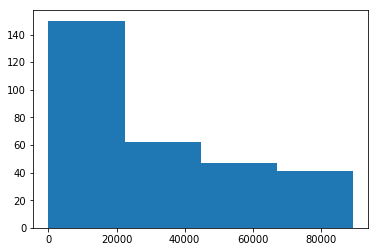

In [162]:
import numpy as np
plt.hist(np.arange(300)**2, bins=4)
plt.show()

In [1]:
lda_model2 = models.ldamodel.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=50, 
                                       random_state=100,
                                       update_every=1,
                                       chunksize=100,
                                       passes=50,
                                       alpha='auto',
                                       per_word_topics=True)

In [ ]:
lda_model2.save()

In [3]:
for j in range(50):
    words = [id2word[i] for i, _ in lda_model.get_topic_terms(j)]
    print(i, " ".join(words))
    print("-"*30)

In [51]:
lda_model2.id2word[5]

'best'

In [25]:
model = lda_model2.load("lda.model")

In [30]:
for i in model.show_topics(50):
    print(*i)
    print("--"*20)

0 0.048*"team" + 0.048*"league" + 0.044*"club" + 0.040*"cup" + 0.038*"play" + 0.031*"player" + 0.029*"season" + 0.028*"win" + 0.022*"goal" + 0.021*"score"
----------------------------------------
1 0.072*"player" + 0.045*"nba" + 0.036*"season" + 0.035*"team" + 0.031*"play" + 0.029*"coach" + 0.028*"all" + 0.025*"win" + 0.023*"game" + 0.023*"time"
----------------------------------------
2 0.237*"british" + 0.085*"uk" + 0.083*"tour" + 0.074*"us" + 0.073*"london" + 0.038*"english" + 0.030*"service" + 0.029*"popularity" + 0.027*"soul" + 0.021*"achieve"
----------------------------------------
3 0.147*"host" + 0.101*"show" + 0.073*"reality" + 0.051*"talk" + 0.048*"channel" + 0.047*"television" + 0.043*"program" + 0.029*"variety" + 0.028*"harry" + 0.024*"mexican"
----------------------------------------
4 0.154*"in" + 0.084*"year" + 0.045*"later" + 0.038*"after" + 0.037*"follow" + 0.035*"begin" + 0.034*"career" + 0.033*"march" + 0.028*"second" + 0.022*"high"
---------------------------------